In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn
import os

In [9]:
def compute_distance(gps_coordinate1, gps_coordinate2):
    ## gps_coordinate1 = [latitude, longitude]
    R = 6371e3;
    latitude1 = math.radians(gps_coordinate1[0])
    latitude2 = math.radians(gps_coordinate2[0])
    longitude1= gps_coordinate1[1]
    longitude2= gps_coordinate2[1]
    
    lat_diff = latitude2 - latitude1
    long_diff= math.radians(longitude2- longitude1)
    
    a = math.pow(math.sin(lat_diff/2), 2) + \
        math.cos(latitude1) * math.cos(latitude2) * \
        math.pow(math.sin(long_diff/2), 2)
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    return distance


thresholdDistance 16.11207938722816
hesitate_time:  2.5600000000000023
pedestrian walk distance:  3.5017667513508366


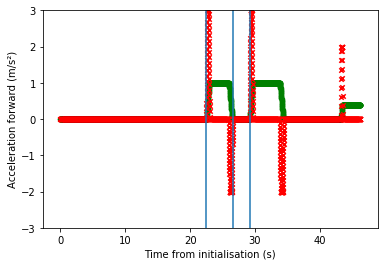

Plot of Ego AV below: 


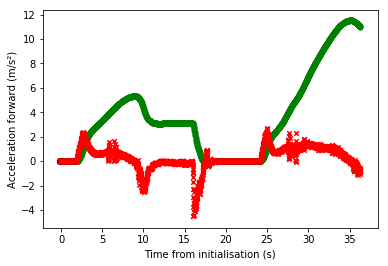

In [10]:
scenario_path = "./LG_Vehicle/Scenario_A2/LG_MKZ-002"

ped_table_list = []
ego_table_list = []

for file in sorted(os.listdir(scenario_path)):
    if("NCom1" in file):
        path_to_file = os.path.join(scenario_path, file)
        ped_table_list.append(pd.read_csv(path_to_file, sep=','))
    if("NCom2" in file):
        path_to_file = os.path.join(scenario_path, file)
        ego_table_list.append(pd.read_csv(path_to_file, sep=','))

# combine different pedestrian .csvs into one dataframe
pedestrian_table = pd.concat(ped_table_list, ignore_index=True)
ego_table        = pd.concat(ego_table_list, ignore_index=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)    


# Parse Scenic Parameters
pos_stopped = []
pos_moving = []
stopped = True
moving  = False
hesitate = False
recorded = False
ped_trigger_time = -1
hesitate_start_time = -1
hesitate_stop_time = -1
ped_start_pos = [pedestrian_table.iloc[0]['Latitude (deg)'], pedestrian_table.iloc[0]['Longitude (deg)']]
ped_stop_pos  = []

for index, row in pedestrian_table.iterrows():   
    accel = pedestrian_table['Acceleration forward (m/s²)'][index]
    speed = pedestrian_table['Speed horizontal (m/s)'][index]

    # Indicates that the pedestrian is stopped
    if speed >= 0 and accel > 0.05:
        pos_moving.append(index)

        if stopped:
            stopped = False
            moving  = True

            if not recorded:
                ped_trigger_time = index
                recorded = True

            if hesitate:
                hesitate_stop_time = row['Time from initialisation (s)']
                break


    if  speed < 0.0005 and accel < 0 :
        pos_stopped.append(index)

        if moving:
            stopped = True
            moving  = False
            hesitate_start_time = row['Time from initialisation (s)']
            ped_stop_pos = [row['Latitude (deg)'], row['Longitude (deg)']]
            hesitate = True

ped_trigger_index  = ped_trigger_time
ped_trigger_pos_x  = pedestrian_table['Latitude (deg)'][ped_trigger_index]
ped_trigger_pos_y  = pedestrian_table['Longitude (deg)'][ped_trigger_index]

ego_trigger_index  = ped_trigger_index
ego_trigger_pos_x  = ego_table['Latitude (deg)'][ego_trigger_index]
ego_trigger_pos_y  = ego_table['Longitude (deg)'][ego_trigger_index]

threshold_dist = compute_distance([ped_trigger_pos_x, ped_trigger_pos_y], [ego_trigger_pos_x, ego_trigger_pos_y])
hesitate_time  = hesitate_stop_time-hesitate_start_time
ped_walkDistance = compute_distance(ped_start_pos, ped_stop_pos)

print("thresholdDistance", threshold_dist)
print("hesitate_time: ", hesitate_time)
print("pedestrian walk distance: ", ped_walkDistance)

ax = pedestrian_table.plot(kind='scatter',x='Time from initialisation (s)',y='Speed horizontal (m/s)',color='green')
pedestrian_table.plot(kind='scatter',x='Time from initialisation (s)',y='Acceleration forward (m/s²)', marker='x', ax = ax ,color='red')
ax.set_ylim(-3, 3)
# ax.set_xlim(37, 40)
plt.axvline(pedestrian_table['Time from initialisation (s)'][ped_trigger_time])
plt.axvline(hesitate_start_time)
plt.axvline(hesitate_stop_time)
plt.show()

print("Plot of Ego AV below: ")
ax = ego_table.plot(kind='scatter',x='Time from initialisation (s)',y='Speed horizontal (m/s)',color='green')
ego_table.plot(kind='scatter',x='Time from initialisation (s)',y='Acceleration forward (m/s²)', marker='x', ax = ax ,color='red')
plt.show()

